# Prep

In [1]:
import sqlite3

import matplotlib
import pandas
import scipy.stats

%matplotlib inline

### Data

In [2]:
db = sqlite3.connect('immigration_analysis.sqlite.db')

In [3]:
source = pandas.read_sql(
    '''
    SELECT
        occupation,
        majorSocCode + 0.0 AS majorSocCode,
        may2020UnemployedCnt + 0.0 AS may2020UnemployedCnt,
        may2020UnemployedRate + 0.0 AS may2020UnemployedRate,
        may2019UnemployedCnt + 0.0  AS may2019UnemployedCnt,
        may2019UnemployedRate + 0.0 AS may2019UnemployedRate,
        totalPositionsCnt + 0.0 AS totalPositionsCnt
    FROM
        unemployment_with_immigration
    ''',
    db
)

In [4]:
source['occupationShort'] = source['occupation'].apply(lambda x: x.replace(' occupations', ''))

### Utility Functions

In [5]:
FONT_FAMILY = 'Lato'

In [6]:
def style_graph(ax, title, x_label, y_label, x_range=None, y_range=None):
    """Style a matplotlib graph.
    
    Args:
        ax: The matplob axes to manipulate.
        title: The string title to have appear at the top of the graphic.
        x_label: The label for the hoizontal axis.
        y_label: The label for the vertical axis.
        x_range: Two element tuple or list with the minimum and maximum values for the horizontal axis.
        y_range: Two element tuple or list with the minimum and maximum values for the vertical axis.
    """
    ax.spines['top'].set_color('#ffffff')
    ax.spines['right'].set_color('#ffffff')
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')

    ax.set_xlabel(x_label, fontname=FONT_FAMILY, fontweight='medium', fontsize=13)
    ax.set_ylabel(y_label, fontname=FONT_FAMILY, fontweight='medium', fontsize=13)

    ax.xaxis.label.set_color('#555555')
    ax.yaxis.label.set_color('#555555')

    ax.tick_params(axis='x', colors='#555555')
    ax.tick_params(axis='y', colors='#555555')

    if x_range:
        ax.set_xlim(x_range)
    
    if y_range:
        ax.set_ylim(y_range)

    if title:
        ax.set_title(title, fontname=FONT_FAMILY, fontweight='medium', fontsize=16, color="#505050")
        ax.title.set_position([.5, 1.05])

    for tick in ax.get_xticklabels():
        tick.set_fontname(FONT_FAMILY)
        tick.set_fontweight('medium')

    for tick in ax.get_yticklabels():
        tick.set_fontweight('medium')

<br>

# EDA / Hypothesis Testing

### Hypothesis 1: The proportion of visa holders is small part of the working force

In [7]:
source['may2020EmployedRate'] = (100 - source['may2020UnemployedRate'])

In [8]:
source['may2020EmployedCnt'] = source['may2020UnemployedCnt'] / source['may2020UnemployedRate'] * source['may2020EmployedRate']

In [9]:
source['percentVisa'] = source['totalPositionsCnt'] / source['may2020EmployedCnt'] * 100

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


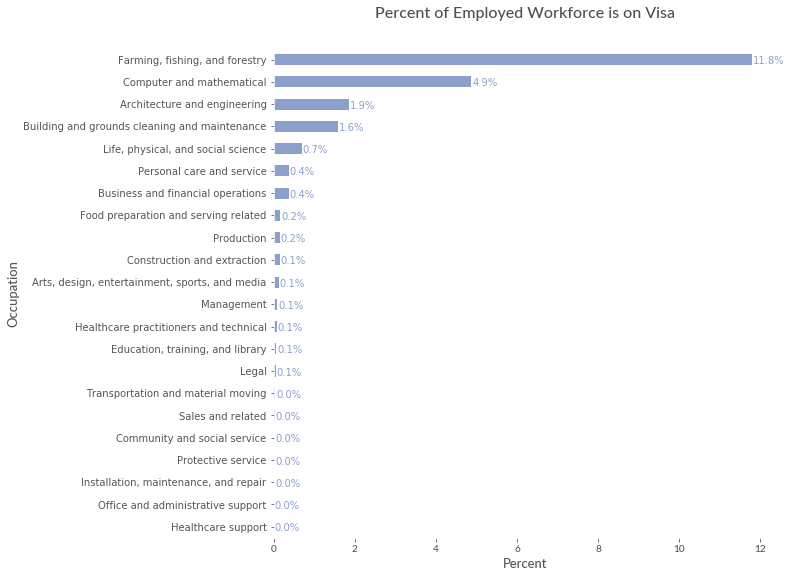

In [10]:
ax = source.sort_values('percentVisa').plot.barh(
    x='occupationShort',
    y='percentVisa',
    figsize=(9, 9),
    legend=None,
    colors=['#8da0cb'] * 22
)

style_graph(ax, 'Percent of Employed Workforce is on Visa', 'Percent', 'Occupation')

for p in ax.patches:
    label_val = '%.1f%%' % p.get_width()
    end_x = p.get_x() + p.get_width() + 0.02
    ax.annotate(label_val, (end_x, p.get_y() + 0.05), color='#8da0cb')

In [11]:
percent_under_1_percent = source[source['percentVisa'] < 1].shape[0] / source.shape[0] * 100

In [12]:
print('Percent occupations under 1%% visa: %.2f%%' % percent_under_1_percent)

Percent occupations under 1% visa: 81.82%


### Hypothesis 2: Occupations with higher unemployment have < 1% H1B

In [13]:
source['changeUnemployedRate'] = source['may2020UnemployedRate'] - source['may2019UnemployedRate']

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


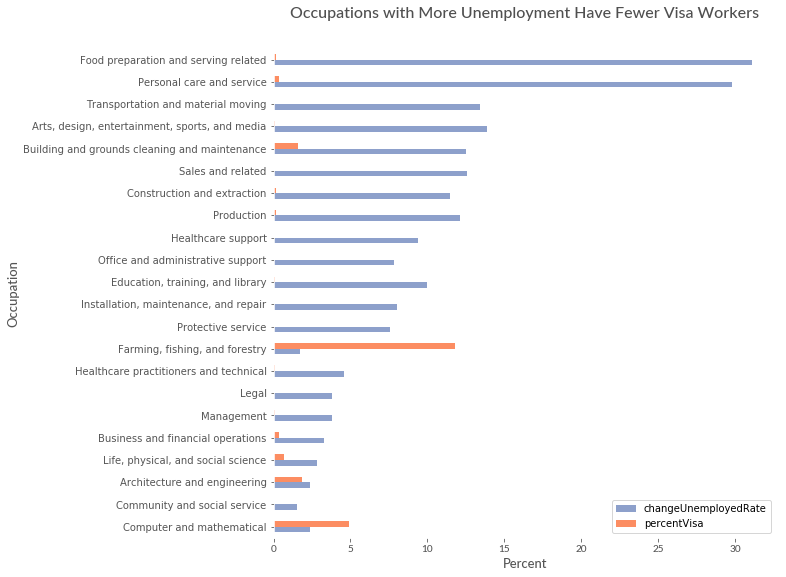

In [14]:
ax = source.sort_values('may2020UnemployedRate').plot.barh(
    x='occupationShort',
    y=['changeUnemployedRate', 'percentVisa'],
    figsize=(9, 9),
    colors=['#8da0cb', '#fc8d62'] * 22
)

style_graph(
    ax,
    'Occupations with More Unemployment Have Fewer Visa Workers',
    'Percent',
    'Occupation'
)

In [15]:
high_visa = source[source['changeUnemployedRate'] >= 5]
low_visa = source[source['changeUnemployedRate'] < 5]

In [16]:
p_value = scipy.stats.mannwhitneyu(high_visa['changeUnemployedRate'], low_visa['changeUnemployedRate'])[1]
if p_value < 0.05:
    print('Hypothesis accepted (%.2f).' % p_value)

Hypothesis accepted (0.00).


In [17]:
print(
    'High unemployment had %.2f%% while low unemployment had %.2f%%.' % (
        high_visa['percentVisa'].mean(),
        low_visa['percentVisa'].mean()
    )
)

High unemployment had 0.21% while low unemployment had 2.21%.


### Hypothesis 3: If all visa jobs went to unemployed, unemployment would not improve substantially

In [18]:
source['hypotheticalUnemploymentCnt'] = source.apply(
    lambda row: max([row['may2020UnemployedCnt'] - row['totalPositionsCnt'], 0]),
    axis=1
)

In [19]:
source['hypotheticalUnemployment'] = source.apply(
    lambda row: row['may2020UnemployedRate'] * (row['hypotheticalUnemploymentCnt'] / row['may2020UnemployedCnt']),
    axis=1
)

In [20]:
source['hypotheticalChangeInUnemployment'] = source['may2020UnemployedRate'] - source['hypotheticalUnemployment']

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


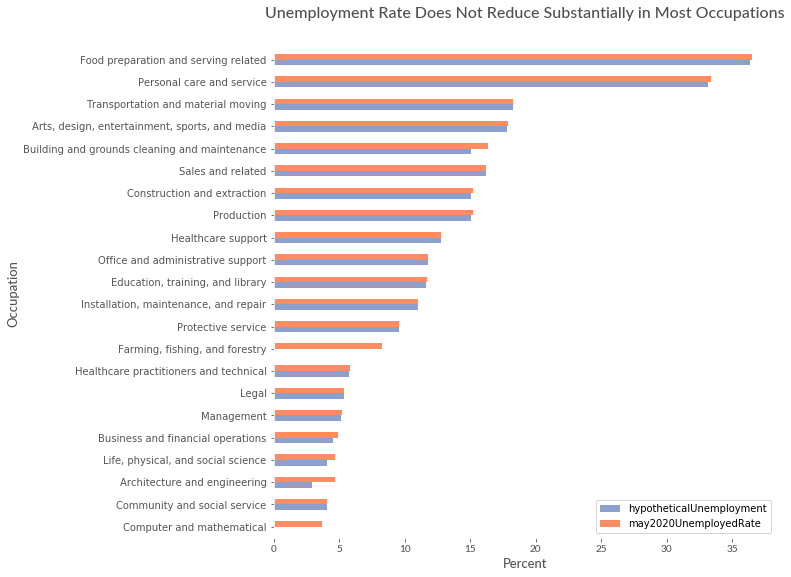

In [21]:
ax = source.sort_values('may2020UnemployedRate').plot.barh(
    x='occupationShort',
    y=['hypotheticalUnemployment', 'may2020UnemployedRate'],
    figsize=(9,9),
    colors=['#8da0cb', '#fc8d62'] * 22
)

style_graph(
    ax,
    'Unemployment Rate Does Not Reduce Substantially in Most Occupations',
    'Percent',
    'Occupation'
)

In [22]:
avg_change_in_unemployment = source['hypotheticalChangeInUnemployment'].mean()

In [23]:
print('Avg change in unemployment: %.2f%%' % avg_change_in_unemployment)

Avg change in unemployment: 0.78%


In [24]:
source[source['hypotheticalChangeInUnemployment'] > 1].shape[0] / source.shape[0]

0.18181818181818182

In [25]:
new_unemployment_rate = source['hypotheticalUnemploymentCnt'].sum() / source['may2020UnemployedCnt'].sum() * 13.3

In [26]:
print('New unemployment rate: %.2f%%' % new_unemployment_rate)

New unemployment rate: 12.91%


# Overall tabs

In [27]:
source['totalPositionsCnt'].sum() / source['may2020EmployedCnt'].sum()

0.004897819956659758

In [28]:
visa_class_counts = pandas.read_sql(
    '''
    SELECT
        visaClass,
        sum(totalWorkerPositionsCnt) AS cnt
    FROM
        immigration_data
    WHERE
        visaActiveDuringMay2020 = "1"
    GROUP BY
        visaClass
    ''',
    db
)

In [29]:
visa_class_counts.to_csv('visa_counts.csv')

In [30]:
visa_class_counts

,visaClass,cnt
0,E-3 Australian,5686
1,H-1B,419076
2,H-1B1 Chile,589
3,H-1B1 Singapore,598
4,H-2A,126422
5,H-2B,123022


In [31]:
pandas.read_sql(
    '''
    SELECT
        sum(totalWorkerPositionsCnt) AS cnt
    FROM
        immigration_data
    WHERE
        visaActiveDuringMay2020 = "1"
    ''',
    db
)

,cnt
0,675393


In [32]:
pandas.read_sql(
    '''
    SELECT
        src.visaClassSimplified AS visaClassSimplified,
        sum(src.cnt) AS cnt
    FROM
        (
            SELECT
                (
                    CASE
                        WHEN visaClass = "H-1B" THEN "H-1B or Similar"
                        WHEN visaClass = "H-1B1 Chile" THEN "H-1B or Similar"
                        WHEN visaClass = "H-1B1 Singapore" THEN "H-1B or Similar"
                        WHEN visaClass = "E-3 Australian" THEN "H-1B or Similar"
                        ELSE visaClass
                    END
                ) AS visaClassSimplified,
                totalWorkerPositionsCnt AS cnt
            FROM
                immigration_data
            WHERE
                visaActiveDuringMay2020 = "1"
        ) src
    GROUP BY
        src.visaClassSimplified
    ''',
    db
)

,visaClassSimplified,cnt
0,H-1B or Similar,425949
1,H-2A,126422
2,H-2B,123022


# Efficiency

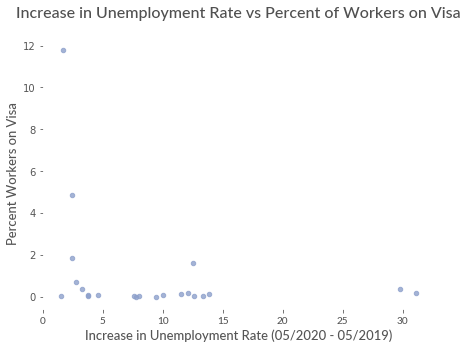

In [33]:
ax = source.sort_values('may2020UnemployedRate').plot.scatter(
    x='changeUnemployedRate',
    y='percentVisa',
    figsize=(7,5),
    color='#8da0cb',
    alpha=0.8,
    s=20
)

style_graph(
    ax,
    'Increase in Unemployment Rate vs Percent of Workers on Visa',
    'Increase in Unemployment Rate (05/2020 - 05/2019)',
    'Percent Workers on Visa'
)

In [34]:
total_visa_positions = source['totalPositionsCnt'].sum()
total_new_jobs = (source['may2020UnemployedCnt'] - source['hypotheticalUnemploymentCnt']).sum()

In [35]:
print('Percent of jobs lost: %.2f%%' % ((1 - total_new_jobs / total_visa_positions) * 100))

Percent of jobs lost: 13.50%


# Output

In [36]:
source.to_csv('unemployment_and_counts_extended.csv')

In [37]:
source.head(5)

,occupation,majorSocCode,may2020UnemployedCnt,may2020UnemployedRate,may2019UnemployedCnt,may2019UnemployedRate,totalPositionsCnt,occupationShort,may2020EmployedRate,may2020EmployedCnt,percentVisa,changeUnemployedRate,hypotheticalUnemploymentCnt,hypotheticalUnemployment,hypotheticalChangeInUnemployment
0,Management occupations,11.0,996000.0,5.2,26800.0,1.4,17528.0,Management,94.8,1.815785e+07,0.096531,3.8,978472.0,5.108488,0.091512
1,Business and financial operations occupations,13.0,436000.0,4.9,13000.0,1.6,31574.0,Business and financial operations,95.1,8.461959e+06,0.373129,3.3,404426.0,4.545155,0.354845
2,Computer and mathematical occupations,15.0,224000.0,3.7,7000.0,1.3,284482.0,Computer and mathematical,96.3,5.830054e+06,4.879577,2.4,0.0,0.000000,3.700000
3,Architecture and engineering occupations,17.0,158000.0,4.7,7800.0,2.3,59699.0,Architecture and engineering,95.3,3.203702e+06,1.863438,2.4,98301.0,2.924144,1.775856
4,"Life, physical, and social science occupations",19.0,80000.0,4.7,2700.0,1.9,11238.0,"Life, physical, and social science",95.3,1.622128e+06,0.692794,2.8,68762.0,4.039767,0.660233
